### Goal
To backdoor into the raw data Chris Martz used to build his Hurricane Frequency chart.

ie, using only the picture of his stacked bar chart, assign data to the stack pieces.

NB: there are multiple region pieces per year, unexpectedly

### Reverse engineering Chris' source data
It was quite the manual process but only took about an hour.

I just looked at a zoomed image of his bar chart and extracted the data with the aid of a quick paper ruler I made (length of 5 with marks at 2 and 3 for ease of identification).

In [1]:
import polars as pl
import helper
import polars.selectors as cs
import altair as alt

In [2]:
chris_data = (
    # pl.read_csv('data/reverse-engineered.csv')
    pl.read_csv('data/reverse-engineered-hurricanes.csv')
    .group_by('basin').sum()
)

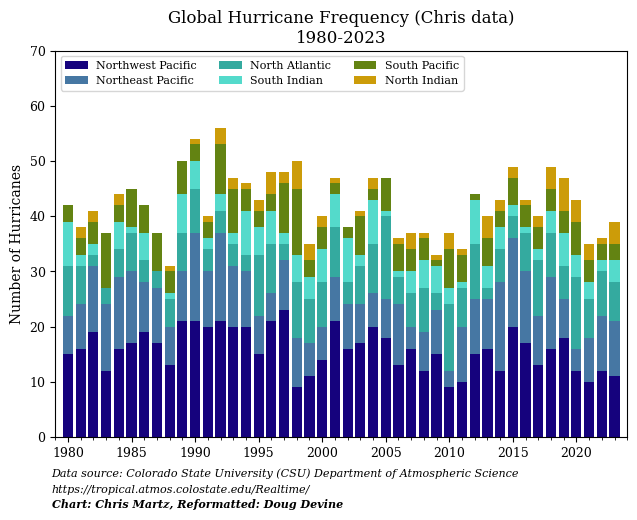

In [3]:
helper.make_chart(chris_data, 'hurricanes')

In [2]:
dude_data = pl.read_parquet('data/chart-source-hurricanes.parquet')

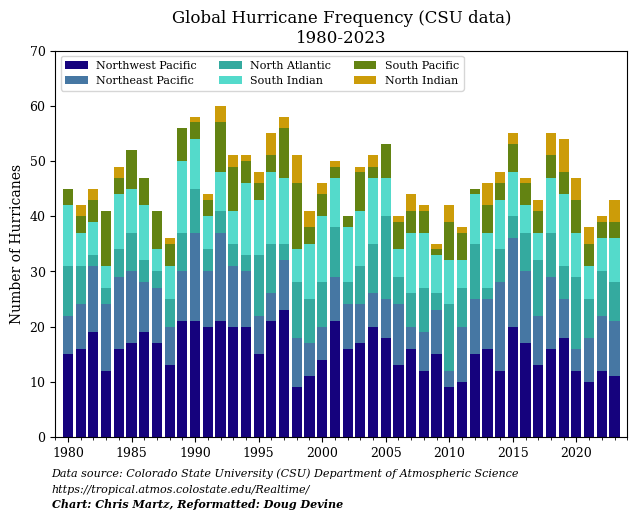

In [3]:
helper.make_chart(dude_data, 'hurricanes')

### Compare my source data versus Chris'

In [ ]:
chris_data

In [13]:
def elongate(df):
    return (
        df
        .unpivot(cs.numeric(), index='basin', variable_name='season', value_name='n')
        # .with_columns(
        #     pl.lit(source).alias('source')
        # )
        # .select(['source', 'region', 'year', 'n_hurricanes'])
    )

In [14]:
diffs = (
    elongate(chris_data)
    .join(elongate(dude_data), on=['basin', 'season'])
    .rename({'n': 'n_chris', 'n_right': 'n_dude'})
    .with_columns(
        (pl.col('n_dude') - pl.col('n_chris')).alias('diff')
    )
)


In [ ]:
diffs

In [ ]:
diffs_scale = alt.Scale(
    domain=[-6, 0, 6],
    range=['red', 'transparent', 'green'],
)

heatmap = alt.Chart(diffs).encode(
    x='season:O',
    y='basin:N',
    color=alt.Color('diff:Q', scale=diffs_scale),
    tooltip=['season', 'basin', 'diff'],
).mark_rect()

text = heatmap.mark_text().encode(
    text=alt.condition(
        alt.datum.value != 0,
        'diff:Q',
        alt.value('x') 
    )
)

chart = alt.layer(heatmap, text).properties(
    title='Differences in hurricane source data (me - Chris)'
)

chart.display()

Unsurprisingly, the glaring difference stems from South Indian data...which was the only region to be duplicated in various years on Chris' chart.